# Accelerating large string data processing with cudf pandas accelerator mode (cudf.pandas)
<a href="https://github.com/rapidsai/cudf">cuDF</a> is a Python GPU DataFrame library (built on the Apache Arrow columnar memory format) for loading, joining, aggregating, filtering, and otherwise manipulating tabular data using a DataFrame style API in the style of pandas.

cuDF now provides a <a href="https://rapids.ai/cudf-pandas/">pandas accelerator mode</a> (`cudf.pandas`), allowing you to bring accelerated computing to your pandas workflows without requiring any code change.

This notebook demonstrates how cuDF pandas accelerator mode can help accelerate processing of datasets with large string fields (4 GB+) processing by simply adding a `%load_ext` command. We have introduced this feature as part of our Rapids 24.08 release.

# ⚠️ Verify your setup

First, we'll verify that you are running with an NVIDIA GPU.

In [ ]:
!nvidia-smi  # this should display information about available GPUs

Wed Aug  7 23:39:46 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   60C    P8              11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# Download the data

The data we'll be working with summarizes job postings data that a developer working at a job listing firm might analyze to understand posting trends.

We're downloading a curated copy of this Kaggle dataset [https://www.kaggle.com/datasets/asaniczka/1-3m-linkedin-jobs-and-skills-2024/data?select=job_summary.csv] directly from the kaggle API. We'll start by downloading the data. This should take about 1-2 minutes.

**Data License and Terms** <br>
As this dataset originates from a Kaggle dataset, it's governed by that dataset's license and terms of use, which is the Open Data Commons license. Review here: https://opendatacommons.org/licenses/by/1-0/index.html . For each dataset an user elects to use, the user is responsible for checking if the dataset license is fit for the intended purpose.

**Are there restrictions on how I can use this data? </br>**
For each dataset an user elects to use, the user is responsible for checking if the dataset license is fit for the intended purpose.



In [ ]:
# Download the dataset through kaggle API-
!kaggle datasets download -d asaniczka/1-3m-linkedin-jobs-and-skills-2024
#unzip the file to access contents
!unzip 1-3m-linkedin-jobs-and-skills-2024.zip

Dataset URL: https://www.kaggle.com/datasets/asaniczka/1-3m-linkedin-jobs-and-skills-2024
License(s): ODC Attribution License (ODC-By)
100% 1.87G/1.88G [00:24<00:00, 135MB/s]
100% 1.88G/1.88G [00:24<00:00, 82.5MB/s]
Archive:  1-3m-linkedin-jobs-and-skills-2024.zip
  inflating: job_skills.csv          
  inflating: job_summary.csv         
  inflating: linkedin_job_postings.csv  


#### **Note**: If you are not running this notebook on Google Colab, you might need to install the Kaggle library using `pip install kaggle`. Additionally, we recommend creating a Kaggle account to download datasets from Kaggle using their CLI. Try running the above cell again after following these instructions.

# Analysis using Standard Pandas

First, let's use Pandas to read in some columns of the dataset:

In [ ]:
import pandas as pd

**Job Summary Dataset** (Dataset-1) : This dataset contains job summaries for each job link.

In [ ]:
%%time
job_summary_df = pd.read_csv("job_summary.csv")
print("Dataset Size (in GB):",round(job_summary_df.memory_usage(
    deep=True).sum()/(1024**3),2))

Dataset Size (in GB): 8.19
CPU times: user 1min 2s, sys: 6.94 s, total: 1min 9s
Wall time: 1min 12s


This **8 GB (in-memory)** dataset took around 1 minute to load!

Let's examine the dataset entries along with their memory footprint and character length.

In [ ]:
job_summary_df.head()

,job_link,job_summary
0,https://www.linkedin.com/jobs/view/restaurant-...,Rock N Roll Sushi is hiring a Restaurant Manag...
1,https://www.linkedin.com/jobs/view/med-surg-re...,Schedule\n: PRN is required minimum 12 hours p...
2,https://www.linkedin.com/jobs/view/registered-...,Description\nIntroduction\nAre you looking for...
3,https://uk.linkedin.com/jobs/view/commercial-a...,Commercial account executive\nSheffield\nFull ...
4,https://www.linkedin.com/jobs/view/store-manag...,Address:\nUSA-CT-Newington-44 Fenn Road\nStore...


The dataset contains job summaries from various job listings.

The `job_summary` column is particularly large, occupying **5 GB in size with a total of 5 billion characters**.

In [ ]:
# Calculate memory usage of each column in GB
memory_usage_bytes = job_summary_df.memory_usage(deep=True)
memory_usage_gb = memory_usage_bytes / (1024 ** 3)

print("`job_summary` column size (in GB):", round(memory_usage_gb['job_summary'],1),
     "\n","`job_summary` column number of characters (in Bn):",
      round(job_summary_df['job_summary'].str.len().sum()/(10**9),2))

`job_summary` column size (in GB): 8.0 
 `job_summary` column number of characters (in Bn): 4.95


**Job Skills Dataset** (Dataset-2): This dataset contains a mapping between job links and the skill tags associated with the link.

In [ ]:
%%time
job_skills_df = pd.read_csv("job_skills.csv")
job_skills_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296381 entries, 0 to 1296380
Data columns (total 2 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   job_link    1296381 non-null  object
 1   job_skills  1294296 non-null  object
dtypes: object(2)
memory usage: 19.8+ MB
CPU times: user 9.58 s, sys: 1.03 s, total: 10.6 s
Wall time: 11.9 s


In [ ]:
job_skills_df.head()

,job_link,job_skills
0,https://www.linkedin.com/jobs/view/housekeeper...,"Building Custodial Services, Cleaning, Janitor..."
1,https://www.linkedin.com/jobs/view/assistant-g...,"Customer service, Restaurant management, Food ..."
2,https://www.linkedin.com/jobs/view/school-base...,"Applied Behavior Analysis (ABA), Data analysis..."
3,https://www.linkedin.com/jobs/view/electrical-...,"Electrical Engineering, Project Controls, Sche..."
4,https://www.linkedin.com/jobs/view/electrical-...,"Electrical Assembly, Point to point wiring, St..."


**Job Postings Dataset** (Dataset - 3): This contains demographic and other work related details for each job posting.

In [ ]:
%%time
job_postings_df = pd.read_csv("linkedin_job_postings.csv")
job_postings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1348454 entries, 0 to 1348453
Data columns (total 14 columns):
 #   Column               Non-Null Count    Dtype 
---  ------               --------------    ----- 
 0   job_link             1348454 non-null  object
 1   last_processed_time  1348454 non-null  object
 2   got_summary          1348454 non-null  object
 3   got_ner              1348454 non-null  object
 4   is_being_worked      1348454 non-null  object
 5   job_title            1348454 non-null  object
 6   company              1348443 non-null  object
 7   job_location         1348435 non-null  object
 8   first_seen           1348454 non-null  object
 9   search_city          1348454 non-null  object
 10  search_country       1348454 non-null  object
 11  search_position      1348454 non-null  object
 12  job_level            1348454 non-null  object
 13  job_type             1348454 non-null  object
dtypes: object(14)
memory usage: 144.0+ MB
CPU times: user 7.62 s, sys:

In [ ]:
job_postings_df.head()

,job_link,last_processed_time,got_summary,got_ner,is_being_worked,job_title,company,job_location,first_seen,search_city,search_country,search_position,job_level,job_type
0,https://www.linkedin.com/jobs/view/account-exe...,2024-01-21 07:12:29.00256+00,t,t,f,Account Executive - Dispensing (NorCal/Norther...,BD,"San Diego, CA",2024-01-15,Coronado,United States,Color Maker,Mid senior,Onsite
1,https://www.linkedin.com/jobs/view/registered-...,2024-01-21 07:39:58.88137+00,t,t,f,Registered Nurse - RN Care Manager,Trinity Health MI,"Norton Shores, MI",2024-01-14,Grand Haven,United States,Director Nursing Service,Mid senior,Onsite
2,https://www.linkedin.com/jobs/view/restaurant-...,2024-01-21 07:40:00.251126+00,t,t,f,RESTAURANT SUPERVISOR - THE FORKLIFT,Wasatch Adaptive Sports,"Sandy, UT",2024-01-14,Tooele,United States,Stand-In,Mid senior,Onsite
3,https://www.linkedin.com/jobs/view/independent...,2024-01-21 07:40:00.308133+00,t,t,f,Independent Real Estate Agent,Howard Hanna | Rand Realty,"Englewood Cliffs, NJ",2024-01-16,Pinehurst,United States,Real-Estate Clerk,Mid senior,Onsite
4,https://www.linkedin.com/jobs/view/group-unit-...,2024-01-19 09:45:09.215838+00,f,f,f,Group/Unit Supervisor (Systems Support Manager...,"IRS, Office of Chief Counsel","Chamblee, GA",2024-01-17,Gadsden,United States,Supervisor Travel-Information Center,Mid senior,Onsite


## Q. Which companies and roles have extremely long job summary?

Long job summaries can be challenging to read, but they are essential for certain roles requiring specific subject matter expertise. It would be interesting to identify which job roles and companies have extremely long summaries.

Let's determine the length of each job summary using the `.str.len()` method in pandas:

In [ ]:
#Calculate Length of job summary -

In [ ]:
%%time
job_summary_df['summary_length'] = job_summary_df['job_summary'].str.len()
job_summary_df['summary_length'].head()

CPU times: user 874 ms, sys: 37.1 ms, total: 911 ms
Wall time: 933 ms


,summary_length
0,957
1,3816
2,5314
3,2774
4,2749


To identify job roles and companies with the longest job summaries, we need to merge the two datasets using the `job_link` column.

In [ ]:
%%time
df_merged=pd.merge(job_postings_df, job_summary_df, how="left", on="job_link")

CPU times: user 2.61 s, sys: 173 ms, total: 2.78 s
Wall time: 2.86 s


Lets finally look at the `job_tile` and `company` with the maximum job summary length through data aggregation.

In [ ]:
%%time
df_merged.groupby(['company',"job_title"]).agg({
    "summary_length":"mean"}).sort_values(by='summary_length', ascending = False).fillna(0)

CPU times: user 2.56 s, sys: 42.7 ms, total: 2.61 s
Wall time: 2.69 s


summary_length
company                        job_title                                                         
ClickJobs.io                   Adolescent Behavioral Health Therapist - Substa...         23748.0
Mt. San Antonio College        Chief, Police and Campus Safety                            22998.0
CareerBeacon                   Airside/Groundside Project Manager [Halifax Int...         22938.0
Tacoma Community College       Anthropology Professor - Part-time                         22790.0
IRS, Office of Chief Counsel   Program Analyst (12-Month Roster)                          22774.0
...                                                                                           ...
鴻海精密工業股份有限公司                   HR Specialist - Payroll & Benefit                              0.0
                               Material Planner                                               0.0
                               RFQ Specialist                                                 0.0
                               Supply Chain Program Manager                                   0.0
🌟Daniel-Scott Recruitment Ltd🌟 IT Manager                                                     0.0

[801276 rows x 1 columns]

We see that some specialized jobs like `Adoloscent Behavioural Therapist`, & `Airside Project Manager` have longer summary length.

## Q. How does the length of job summary varies by location?

Why stop here?

Another interesting trend would be to see whether job summary length changes with location. Hopefully, the role requirements shouldn't be biased by the location.

In [ ]:
%%time
# Group by company, job_title, and month, and calculate the mean of summary_length
grouped_df = df_merged.groupby(['job_title', 'job_location']).agg({'summary_length': 'mean'})

# Reset index to sort by job_title and month
grouped_df = grouped_df.reset_index()

# Sort by job_title and month
sorted_df = grouped_df.sort_values(by=['job_title', 'job_location','summary_length'],
                                   ascending=False).reset_index(drop=True).fillna(0)
sorted_df

CPU times: user 5.31 s, sys: 44.5 ms, total: 5.35 s
Wall time: 5.42 s


,job_title,job_location,summary_length
0,"🔥Nurse Manager, Patient Services - Operating Room","Lake George, NY",7342.0
1,🔥Behavioral Health RN 3 12s,"Glens Falls, NY",2787.0
2,🔥 Surgical Technologist - Evenings,"Lake George, NY",2920.0
3,🔥 Physician Practice Clinical Lead RN,"Saratoga Springs, NY",2945.0
4,🔥 Physican Practice LPN - Green,"Lake George, NY",2969.0
...,...,...,...
1104106,"""Attorney"" (Gov Appt/Non-Merit) Jobs","Kentucky, United States",2427.0
1104107,"""Accountant""","Shavano Park, TX",1497.0
1104108,"""Accountant""","Basking Ridge, NJ",1073.0
1104109,"""Accountant""","Austin, TX",1993.0


Let's analyze the job role `LEAD SALES ASSOCIATE-FT` to see if the job summary changes with its postings across different locations.

In [ ]:
# isolating records for the specific job role across various location
job_title_acc=sorted_df[sorted_df['job_title'] == 'LEAD SALES ASSOCIATE-FT'].reset_index(
    drop=True)[1:15]

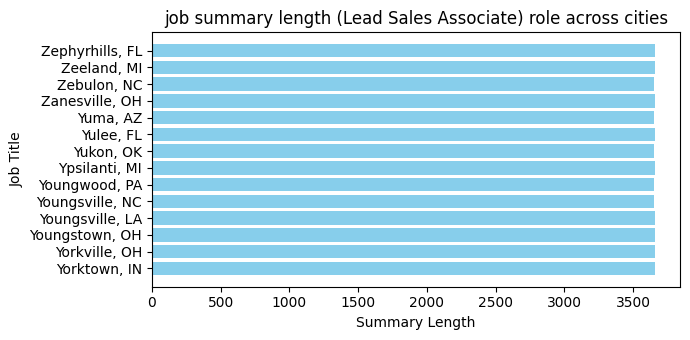

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 3.5))
plt.barh(job_title_acc['job_location'],job_title_acc['summary_length'], color='skyblue')
plt.xlabel('Summary Length')
plt.ylabel('Job Title')
plt.title('job summary length (Lead Sales Associate) role across cities')
plt.gca().invert_yaxis()  # To display the highest values at the top
plt.tight_layout()
plt.show()

The `Lead Sales Associate` role has similar job summary lengths across various cities, indicating that job requirements for this role remain consistent regardless of location.

# Analysis with cuDF Pandas

Let's first install cudf latest version-

In [ ]:
!pip install --extra-index-url=https://pypi.nvidia.com cudf-cu12==24.8.*

Typically, you should load the `cudf.pandas` extension as the first step in your notebook, before importing any modules. Here, we explicitly restart the kernel to simulate that behavior.

In [ ]:
get_ipython().kernel.do_shutdown(restart=True)

{'status': 'ok', 'restart': True}

Note: We just added the `%load-ext` and the rest of the code remains the same.

In [ ]:
%load_ext cudf.pandas
import pandas as pd

We'll run the same code as above to get a feel what GPU-acceleration brings to pandas workflows.

In [ ]:
%time job_summary_df = pd.read_csv("job_summary.csv")
print("Dataset Size (in GB):",round(job_summary_df.memory_usage(
    deep=True).sum()/(1024**3),2))

CPU times: user 3.07 s, sys: 2.41 s, total: 5.48 s
Wall time: 14.2 s
Dataset Size (in GB): 4.76


The same dataset takes about around 1.5 minutes to load with pandas. That's around **5x speedup** with no changes to the code!

Let's load the remaining two datasets as well:

In [ ]:
%%time
job_skills_df = pd.read_csv("job_skills.csv")
job_postings_df = pd.read_csv("linkedin_job_postings.csv")

CPU times: user 684 ms, sys: 154 ms, total: 838 ms
Wall time: 879 ms


In [ ]:
%%time
job_summary_df['summary_length'] = job_summary_df['job_summary'].str.len()
job_summary_df['summary_length'].head()

CPU times: user 29.7 ms, sys: 7.54 ms, total: 37.2 ms
Wall time: 66.4 ms


,summary_length
0,957
1,3816
2,5314
3,2774
4,2749


That was lightning fast! We went from around 10+ (with pandas) to a few milliseconds.

In [ ]:
%%time
df_merged=pd.merge(job_postings_df, job_summary_df, how="left", on="job_link")
df_merged.head()

CPU times: user 10.3 s, sys: 494 ms, total: 10.8 s
Wall time: 11.2 s


,job_link,last_processed_time,got_summary,got_ner,is_being_worked,job_title,company,job_location,first_seen,search_city,search_country,search_position,job_level,job_type,job_summary,summary_length
0,https://www.linkedin.com/jobs/view/account-exe...,2024-01-21 07:12:29.00256+00,t,t,f,Account Executive - Dispensing (NorCal/Norther...,BD,"San Diego, CA",2024-01-15,Coronado,United States,Color Maker,Mid senior,Onsite,Responsibilities\nJob Description Summary\nJob...,4602.0
1,https://www.linkedin.com/jobs/view/registered-...,2024-01-21 07:39:58.88137+00,t,t,f,Registered Nurse - RN Care Manager,Trinity Health MI,"Norton Shores, MI",2024-01-14,Grand Haven,United States,Director Nursing Service,Mid senior,Onsite,Employment Type:\nFull time\nShift:\nDescripti...,2950.0
2,https://www.linkedin.com/jobs/view/restaurant-...,2024-01-21 07:40:00.251126+00,t,t,f,RESTAURANT SUPERVISOR - THE FORKLIFT,Wasatch Adaptive Sports,"Sandy, UT",2024-01-14,Tooele,United States,Stand-In,Mid senior,Onsite,Job Details\nDescription\nWhat You'll Do\nAs a...,4571.0
3,https://www.linkedin.com/jobs/view/independent...,2024-01-21 07:40:00.308133+00,t,t,f,Independent Real Estate Agent,Howard Hanna | Rand Realty,"Englewood Cliffs, NJ",2024-01-16,Pinehurst,United States,Real-Estate Clerk,Mid senior,Onsite,Who We Are\nRand Realty is a family-owned brok...,3944.0
4,https://www.linkedin.com/jobs/view/group-unit-...,2024-01-19 09:45:09.215838+00,f,f,f,Group/Unit Supervisor (Systems Support Manager...,"IRS, Office of Chief Counsel","Chamblee, GA",2024-01-17,Gadsden,United States,Supervisor Travel-Information Center,Mid senior,Onsite,None,NaN


In [ ]:
%%time
df_merged.groupby(['company',"job_title"]).agg({
    "summary_length":"mean"}).sort_values(by='summary_length', ascending = False).fillna(0)

CPU times: user 440 ms, sys: 82.1 ms, total: 522 ms
Wall time: 615 ms


summary_length
company                        job_title                                                         
ClickJobs.io                   Adolescent Behavioral Health Therapist - Substa...         23748.0
Mt. San Antonio College        Chief, Police and Campus Safety                            22998.0
CareerBeacon                   Airside/Groundside Project Manager [Halifax Int...         22938.0
Tacoma Community College       Anthropology Professor - Part-time                         22790.0
IRS, Office of Chief Counsel   Program Analyst (12-Month Roster)                          22774.0
...                                                                                           ...
鴻海精密工業股份有限公司                   HR Specialist - Payroll & Benefit                              0.0
                               Material Planner                                               0.0
                               RFQ Specialist                                                 0.0
                               Supply Chain Program Manager                                   0.0
🌟Daniel-Scott Recruitment Ltd🌟 IT Manager                                                     0.0

[801276 rows x 1 columns]

We went down from around 5 seconds to less than a second here. This is in line with our speedups on other operations!

In [ ]:
%%time
# Group by company, job_title, and month, and calculate the mean of summary_length
grouped_df = df_merged.groupby(['job_title', 'job_location']).agg({'summary_length': 'mean'})

# Reset index to sort by job_title and month
grouped_df = grouped_df.reset_index()

# Sort by job_title and month
sorted_df = grouped_df.sort_values(by=['job_title', 'job_location','summary_length'],
                                   ascending=False).reset_index(drop=True).fillna(0)
sorted_df

CPU times: user 444 ms, sys: 59 ms, total: 503 ms
Wall time: 516 ms


,job_title,job_location,summary_length
0,"🔥Nurse Manager, Patient Services - Operating Room","Lake George, NY",7342.0
1,🔥Behavioral Health RN 3 12s,"Glens Falls, NY",2787.0
2,🔥 Surgical Technologist - Evenings,"Lake George, NY",2920.0
3,🔥 Physician Practice Clinical Lead RN,"Saratoga Springs, NY",2945.0
4,🔥 Physican Practice LPN - Green,"Lake George, NY",2969.0
...,...,...,...
1104106,"""Attorney"" (Gov Appt/Non-Merit) Jobs","Kentucky, United States",2427.0
1104107,"""Accountant""","Shavano Park, TX",1497.0
1104108,"""Accountant""","Basking Ridge, NJ",1073.0
1104109,"""Accountant""","Austin, TX",1993.0


The acceleration is consistently 10x+ for complex aggregations and sorting that involve multiple columns.

# Summary

With cudf.pandas, you can keep using pandas as your primary dataframe library. When things start to get a little slow, just load the `cudf.pandas` extension and enjoy the incredible speedups.

If you like Google Colab and want to get peak `cudf.pandas` performance to process even larger datasets, Google Colab's paid tier includes both L4 and A100 GPUs (in addition to the T4 GPU this demo notebook is using).

To learn more about cudf.pandas, we encourage you to visit https://rapids.ai/cudf-pandas.

# Do you have any feedback for us?

Fill this quick survey <a href="https://www.surveymonkey.com/r/TX3QQQR">HERE</a>

Raise an issue on our github repo <a href="https://github.com/rapidsai/cudf/issues">HERE</a>